                            Sprawozdanie
                            
Jan Nowak 268357
Podstawowy pseudokod:
Klasa Sequence:
    - sequence
    - name
    - id

Funkcja get_uniprot_sequence(uniprot_id):
    - Pobierz sekwencję z bazy danych Uniprot na podstawie ID

Funkcja seqConstructor(fasta_data):
    - Przetwórz dane FASTA na obiekt Sequence

Klasa Dotplot:
    - array
    - seq1Id
    - seq2Id
    - seq1Name
    - seq2Name

Funkcja dotplot(seq1, seq2):
    - Utwórz macierz kropkową dla dwóch sekwencji

Funkcja filtruj(window, threshold):
    - Filtrowanie macierzy kropkowej na podstawie okna i progu

Główna funkcja:
    - Pobierz dwie sekwencje (od użytkownika lub z Uniprot)
    - Utwórz macierz kropkową dla dwóch sekwencji
    - Wygeneruj wykres macierzy kropkowej
    - Zastosuj filtrację na macierzy kropkowej
    - Wygeneruj wykres macierzy kropkowej po filtracji
    - Zapisz macierz kropkową do pliku tekstowego
    
Kod programu:


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Dotplot:
    def __init__(self, array, seq1Id="1", seq2Id="2", seq1Name="Seq 1", seq2Name="Seq 2"):
        self.array = array
        self.size = array.shape
        self.seq1Id = seq1Id
        self.seq2Id = seq2Id
        self.seq1Name = seq1Name
        self.seq2Name = seq2Name

    @classmethod
    def from_sequences(cls, seq1, seq2):
        len_seq1 = len(seq1.sequence)
        len_seq2 = len(seq2.sequence)

        dp = np.zeros((len_seq1, len_seq2), dtype=int)

        for i in range(len_seq1):
            for j in range(len_seq2):
                if seq1.sequence[i] == seq2.sequence[j]:
                    dp[i, j] = 1

        return cls(dp, seq1.id, seq2.id, seq1.name, seq2.name)

    def __getitem__(self, index):
        return self.array[index]

    def __setitem__(self, index, val):
        self.array[index] = val

    def __str__(self):
        return str(self.array)

    def save_txt(self, filename):
        np.savetxt(filename, self.array, fmt="%d")

    def graphic(self, filename, title="Dotplot Matrix", window=None, threshold=None):
        plt.imshow(self.array, cmap='binary', interpolation='nearest')
        plt.title(title)
        plt.xlabel(f"{self.seq2Name} {self.seq2Id}")
        plt.ylabel(f"{self.seq1Name} {self.seq1Id}")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

        # Dodanie skali
        plt.colorbar(label='Intensity')

        # Dodanie legendy z parametrami filtracji
        if window is not None and threshold is not None:
            plt.text(0.9, -0.1, f"Window: {window}, Threshold: {threshold}",
                     horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        plt.savefig(filename)
        plt.show()

    def filter(self, window, threshold):
        wynik = np.zeros_like(self.array)
        high, width = self.array.shape

        for i in range(high - window + 1):
            for j in range(width - window + 1):
                sum_diag = np.sum(np.diagonal(self.array[i:i+window, j:j+window]))
                if sum_diag >= threshold:
                    wynik[i, j] = 1

        return Dotplot(wynik, self.seq1Id, self.seq2Id, self.seq1Name, self.seq2Name)



In [2]:
import numpy as np

from Dotplot import Dotplot


class Sequence:
    def __init__(self, seq, name="default", id=000000):
        self.sequence = seq
        self.length = len(seq)
        self.name = name
        self.id = id

    def __str__(self):
        return self.sequence

    def get_length(self):
        return self.length

    def dotplot(self, seq2):
        dp = np.zeros((self.length, seq2.get_length()))
        for i in range(self.length):
            for j in range(seq2.get_length()):
                if self.sequence[i] == seq2.sequence[j]:
                    dp[i, j] = 1
                else:
                    dp[i, j] = 0
        return Dotplot(dp)



In [3]:
import requests
from Sequence import Sequence
from Dotplot import Dotplot
import re
import numpy as np

def seqConstructor(fasta_data):
    lines = fasta_data.split('\n')

    # czy sekwencja zawiera nagłówek
    if not lines[0].startswith('>'):
        print("Błąd: Brak nagłówka w sekwencji FASTA.")
        return None

    seq = ''.join(lines[1:])

    # czy sekwencja zawiera nielegalne znaki
    basic_amino_acids = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W',
                         'Y'}

    if not set(seq).issubset(basic_amino_acids):
        print("Błąd: Sekwencja zawiera nielegalne znaki.")
        return None

    match = re.match(r">sp\|(\w+)\|(\w+)OS", lines[0])
    id = None
    name = None
    if match:
        id = match.group(1)
        name = match.group(2)

    protein = Sequence(seq, id, name)
    return protein


def get_uniprot_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Sprawdź, czy odpowiedź nie zawiera błędu HTTP
        fasta_data = response.text
        seq = seqConstructor(fasta_data)
        return seq
    except requests.exceptions.HTTPError as e:
        print(f"Wystąpił błąd HTTP: {e}")
        return None
    except Exception as e:
        print(f"Wystąpił inny błąd: {e}")
        return None


def start():
    while True:
        print("Wybierz metodę wprowadzania sekwencji: plik FASTA(1) lub ID Uniprot(2)")
        choice = input()
        if choice == "1":
            print("Podaj nazwę pliku")
            name = input()
            seq = ""  
            try:
                with open(name, "r") as f: 
                    read = f.read()
                    seq = seqConstructor(read)
            except IOError as e:
                print("Wystąpił wyjątek:", e)
            return seq
        elif choice == "2":
            print("Podaj ID Uniprot")
            uniprot_id = input()
            seq = get_uniprot_sequence(uniprot_id)
            if seq:
                return seq
            else:
                print("Nie udało się pobrać sekwencji dla podanego ID Uniprot.")
        else:
            print("Błędna opcja")



#print("Wybierz pierwszą sekwencję:")
#seq1 = start()
#print("Wybierz drugą sekwencję:")
#seq2 = start()



Analiza złożoności obliczeniowej czasowej
W przypadku sekwencji o długości n i m, złożoność obliczeniowa algorytmu tworzenia macierzy kropkowej wynosi O(n * m), ponieważ musimy porównać każdyznak z sekwencji pierwszej z każdym znakiem z sekwencji drugiej.
Dla filtracji ta złożoność rośnie i zależy od k^2.

Porównanie przykładowych par sekwencji ewolucyjnie powiązanych:

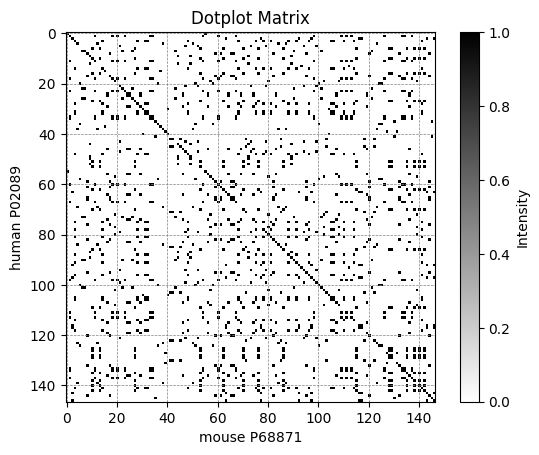

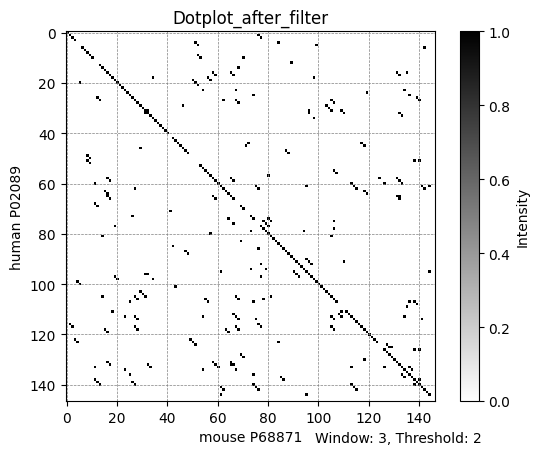

In [8]:
from Sequence import Sequence
from Dotplot import Dotplot
seq1 = Sequence("MVHLTDAEKSAVSCLWAKVNPDEVGGEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNPKVKAHGKKVITAFNEGLKNLDNLKGTFASLSELHCDKLHVDPENFRLLGNAIVIVLGHHLGKDFTPAAQAAFQKVVAGVATALAHKYH", "human", "P02089")
seq2 = Sequence("MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH", "mouse", "P68871")
dp = Dotplot.from_sequences(seq1, seq2)
dp.graphic("matrix1")
dp = dp.filter(3, 2)
dp.graphic("matrix2", "Dotplot_after_filter", 3, 2)

Na dotplocie po filtracji wyraźnie widać miejsca przerwań. Te obszary sekwencji sobie nie odpowiadają co jest najprawdopodobinej wynikiem podstawienia - substytucji. 

Porównanie przykładowych par sekwencji ewolucyjnie niepowiązanych:
(izolowanie nazwy z fasta sprawia trudności bo zdarzają się odstępstwa od formatu)

Wybierz metodę wprowadzania sekwencji: plik FASTA(1) lub ID Uniprot(2)
Podaj nazwę pliku


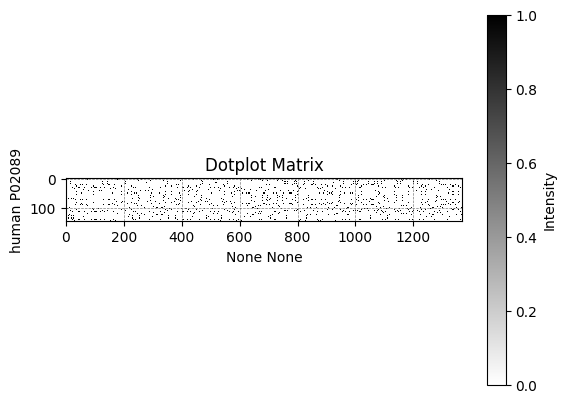

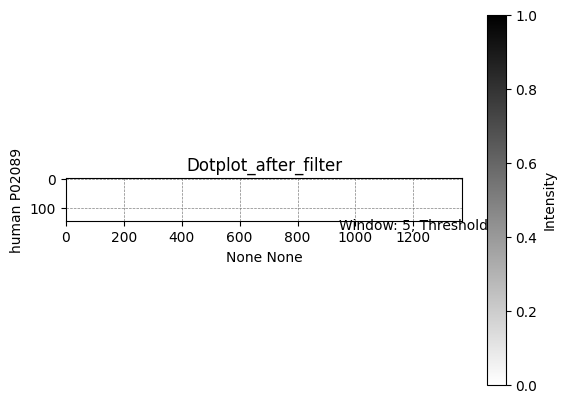

In [7]:
from Sequence import Sequence
from Dotplot import Dotplot
seq1 = Sequence("MVHLTDAEKSAVSCLWAKVNPDEVGGEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNPKVKAHGKKVITAFNEGLKNLDNLKGTFASLSELHCDKLHVDPENFRLLGNAIVIVLGHHLGKDFTPAAQAAFQKVVAGVATALAHKYH", "human", "P02089")
seq2 = start()
#P06213 z uniprot
dp = Dotplot.from_sequences(seq1, seq2)
dp.graphic("matrix1")
dp = dp.filter(5, 4)
dp.graphic("matrix2", "Dotplot_after_filter", 5, 4)